# Creating a Correlation Graph for A and B Channel Data

Purpose is to create a 4 by 4 grid of correlation plots of each sensor

- X is B PM2.5_atm, Y is A Pm2.5_atm
- 24 hour average
- Mark outliers red that 1) exceed absolute difference 5 ug/m3 and/or 2) exceed 16% error with channel A baseline

https://cfpub.epa.gov/si/si_public_record_Report.cfm?Lab=CEMM&dirEntryId=348236

## Setup and Importing Data

First import required packages.

In [2]:
import pandas as pd
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

Then import the preprocessed data. Channel A data is stored in a dataframe named data_A, and channel B data is stored in the dataframe data_B.

In [3]:
data_A = pd.read_parquet('../data/interim/PurpleAir MASTER realtime individual.parquet')[['PM2.5_ATM_ug/m3']]
print('Primary_A imported')
data_B = pd.read_parquet('../data/interim/PurpleAir B MASTER realtime individual.parquet')[['PM2.5_ATM_ug/m3']]
print('Primary_B imported')

Primary_A imported
Primary_B imported


## Performing Resampling on DataFrame

Both of these dataframes use a multiindex consisting of (sensor_name,created_at). So resampling must be performed in a specific way in order to obtain the intend result. If you just use df.resample(), it will average all the sensors together, essentially erasing the sensor_name component of the index. However, we get daily averaged data PER CITY, so we utilize the methods described in this [stackoverflow answer](https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex) to do exactly that using groupby instructions. I also just appended a .rename() to each line, because it was more convenient than writing another variable assignment (like data_A = data_A.rename()).

In [4]:
# https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex
data_A = data_A.groupby([pd.Grouper(level='sensor_name'),pd.Grouper(level='created_at', freq='D')]).mean()\
    .rename(columns={'PM2.5_ATM_ug/m3':'Channel A PM2.5 (ug/m3)'})
data_B = data_B.groupby([pd.Grouper(level='sensor_name'),pd.Grouper(level='created_at', freq='D')]).mean()\
    .rename(columns={'PM2.5_ATM_ug/m3':'Channel B PM2.5 (ug/m3)'})

## Data Analysis

Now that our A and B dataframes are ready, we will combine them and perform some calculations:
1. Concat dataframes with axis=1 to add columns and 'inner' to intersect the indices
2. Do percent error with A data as theoretical
3. Determine if each value is an outlier or not with boolean output
4. Bound of 40 on x-axis and y-axis because some outliers reach the thousands and make it hard to read relevant data

In [36]:
def mark_outliers(data_A, data_B, bound=100):
    data = pd.concat([data_A, data_B], axis=1,join='inner')
    data['diff'] =  abs(data['Channel A PM2.5 (ug/m3)']-data['Channel B PM2.5 (ug/m3)'])
    data['percent_error'] = data['diff']*100/data['Channel A PM2.5 (ug/m3)']
    data['outlier'] = (data['diff'] > 5) & (data['percent_error'] > 16)
    data = data.loc[(data['Channel A PM2.5 (ug/m3)']<bound) &(data['Channel B PM2.5 (ug/m3)']<bound)]
    return data

data = mark_outliers(data_A, data_B)

## Use Seaborn to Create a Scatter Facet Grid
https://seaborn.pydata.org/tutorial/axis_grids.html


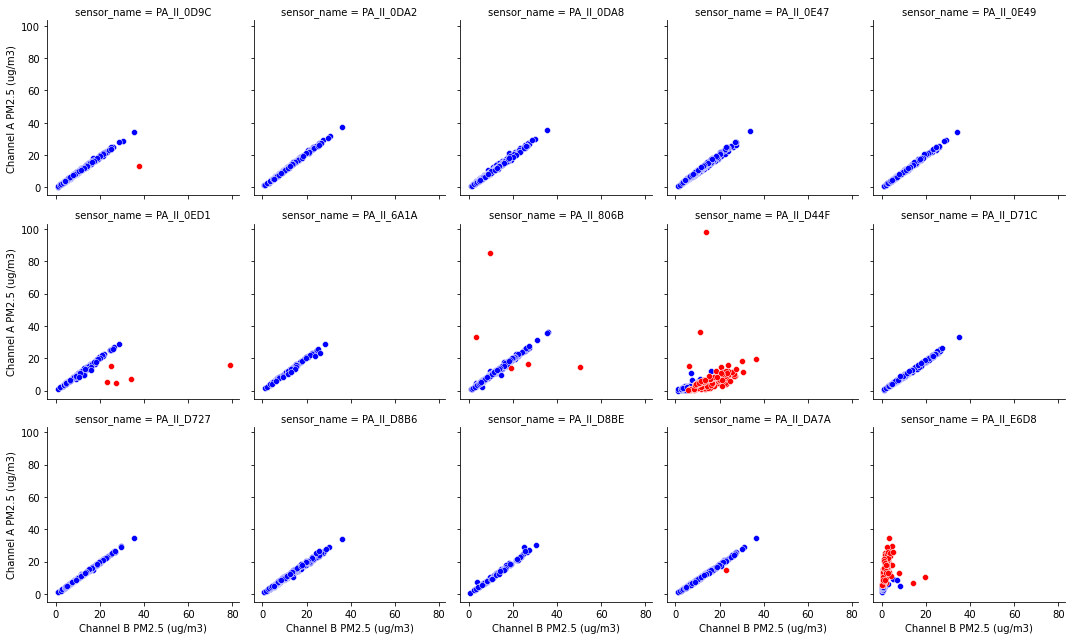

In [37]:
g = sns.FacetGrid(data.reset_index().set_index('created_at'), col="sensor_name", hue='outlier', palette=['blue','red'], col_wrap=5)
g.map(sns.scatterplot,'Channel B PM2.5 (ug/m3)','Channel A PM2.5 (ug/m3)')

In [13]:
def remove_marked_outliers(data):
    data_cleaned = data.loc[data.loc[:,'outlier']==False]
    return data_cleaned
data_cleaned = remove_marked_outliers(data)

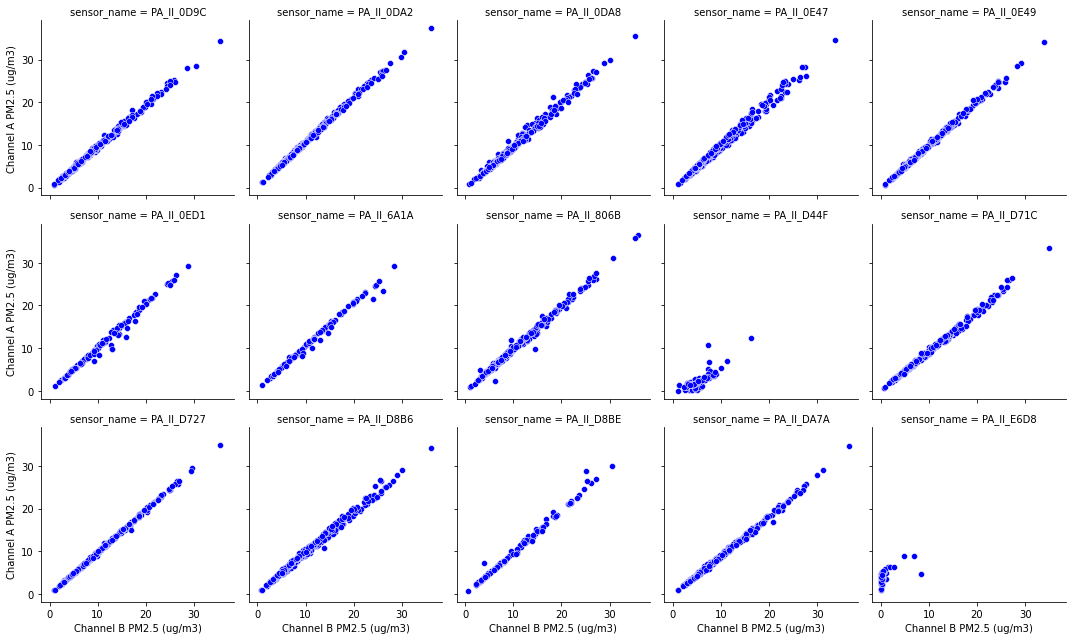

In [14]:
g = sns.FacetGrid(data_cleaned.reset_index().set_index('created_at'), col="sensor_name", hue='outlier', palette=['blue','red'], col_wrap=5)
g.map(sns.scatterplot,'Channel B PM2.5 (ug/m3)','Channel A PM2.5 (ug/m3)')

In [29]:
dat_A = pd.read_parquet('../data/interim/PurpleAir MASTER realtime individual.parquet').rename(columns={'PM2.5_ATM_ug/m3':'Channel A PM2.5 (ug/m3)'})
dat_B = pd.read_parquet('../data/interim/PurpleAir B MASTER realtime individual.parquet').rename(columns={'PM2.5_ATM_ug/m3':'Channel B PM2.5 (ug/m3)'})

In [30]:
dat = pd.concat([dat_A, dat_B[['Channel B PM2.5 (ug/m3)']]], axis=1,join='inner')

In [31]:
def mark_outliers1(data, bound=100):
    data['diff'] =  abs(data['Channel A PM2.5 (ug/m3)']-data['Channel B PM2.5 (ug/m3)'])
    data['percent_error'] = data['diff']*100/data['Channel A PM2.5 (ug/m3)']
    data['outlier'] = (data['diff'] > 5) & (data['percent_error'] > 16)
    data = data.loc[(data['Channel A PM2.5 (ug/m3)']<bound) &(data['Channel B PM2.5 (ug/m3)']<bound)]
    return data


dat_marked = mark_outliers1(dat)

In [32]:
dat_marked

entry_id  PM1.0_CF1_ug/m3  \
sensor_name created_at                                             
PA_II_0D9C  2019-12-31 18:00:00-06:00   98854.0             0.76   
            2019-12-31 18:02:00-06:00   98855.0             0.88   
            2019-12-31 18:06:00-06:00   98857.0             0.61   
            2019-12-31 18:08:00-06:00   98858.0             0.53   
            2019-12-31 18:10:00-06:00   98859.0             1.17   
...                                         ...              ...   
PA_II_E6D8  2020-09-15 18:50:00-05:00  299734.0             8.85   
            2020-09-15 18:52:00-05:00  299735.0             8.37   
            2020-09-15 18:54:00-05:00  299736.0             8.71   
            2020-09-15 18:56:00-05:00  299737.0             8.44   
            2020-09-15 18:58:00-05:00  299738.0             7.69   

                                       PM2.5_CF1_ug/m3  PM10.0_CF1_ug/m3  \
sensor_name created_at                                                     
PA_II_0D9C  2019-12-31 18:00:00-06:00             1.31              1.31   
            2019-12-31 18:02:00-06:00             1.22              1.29   
            2019-12-31 18:06:00-06:00             1.04              1.19   
            2019-12-31 18:08:00-06:00             1.04              1.18   
            2019-12-31 18:10:00-06:00             1.59              1.59   
...                                                ...               ...   
PA_II_E6D8  2020-09-15 18:50:00-05:00            13.29             13.67   
            2020-09-15 18:52:00-05:00            12.96             13.54   
            2020-09-15 18:54:00-05:00            13.51             14.24   
            2020-09-15 18:56:00-05:00            12.78             13.24   
            2020-09-15 18:58:00-05:00            12.75             13.20   

                                       UptimeMinutes  RSSI_dbm  Temperature_F  \
sensor_name created_at                                                          
PA_II_0D9C  2019-12-31 18:00:00-06:00        36036.0     -47.0           62.0   
            2019-12-31 18:02:00-06:00        36038.0     -50.0           62.0   
            2019-12-31 18:06:00-06:00        36042.0     -52.0           61.0   
            2019-12-31 18:08:00-06:00        36044.0     -47.0           61.0   
            2019-12-31 18:10:00-06:00        36046.0     -49.0           61.0   
...                                              ...       ...            ...   
PA_II_E6D8  2020-09-15 18:50:00-05:00        32764.0     -80.0           92.0   
            2020-09-15 18:52:00-05:00        32766.0     -82.0           92.0   
            2020-09-15 18:54:00-05:00        32768.0     -84.0           92.0   
            2020-09-15 18:56:00-05:00        32770.0     -83.0           92.0   
            2020-09-15 18:58:00-05:00        32772.0     -84.0           93.0   

                                       Humidity_%  Channel A PM2.5 (ug/m3)  \
sensor_name created_at                                                       
PA_II_0D9C  2019-12-31 18:00:00-06:00        21.0                     1.31   
            2019-12-31 18:02:00-06:00        21.0                     1.22   
            2019-12-31 18:06:00-06:00        21.0                     1.04   
            2019-12-31 18:08:00-06:00        22.0                     1.04   
            2019-12-31 18:10:00-06:00        22.0                     1.59   
...                                           ...                      ...   
PA_II_E6D8  2020-09-15 18:50:00-05:00        43.0                    13.29   
            2020-09-15 18:52:00-05:00        43.0                    12.96   
            2020-09-15 18:54:00-05:00        43.0                    13.51   
            2020-09-15 18:56:00-05:00        42.0                    12.78   
            2020-09-15 18:58:00-05:00        42.0                    12.75   

                                            lat        lon  \
sensor_name created_at            

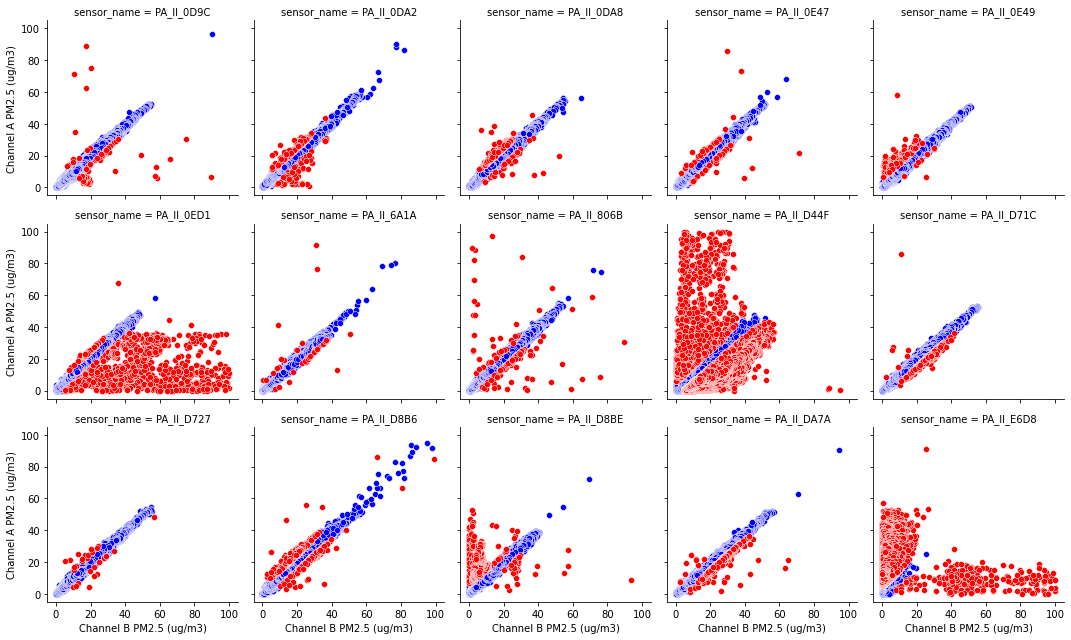

In [33]:
g = sns.FacetGrid(dat_marked.reset_index().set_index('created_at'), col="sensor_name", hue='outlier', palette=['blue','red'], col_wrap=5)
g.map(sns.scatterplot,'Channel B PM2.5 (ug/m3)','Channel A PM2.5 (ug/m3)')